In [1]:
import sys
sys.path.append('/home/gergedan/WS24/thesis/code')

import autograd.numpy as np
import matplotlib.pyplot as plt

from NN.extreme_learning_machine import ELM
from draw import draw_1d

## **1-D Example**
### Here is the toy function that we want to approximate 

$$
  f(x) = \frac{x^{3}}{3} - \frac{x^{2}}{2} - \frac{1}{2} \cos{(x^{2})}
$$

$$
  \frac{\partial f(x)}{\partial x} = x^{2} - x + \sin{(x^{2})}x
$$

Where $x \in \mathbb{R}$ and $f(x) \in \mathbb{R}$ 

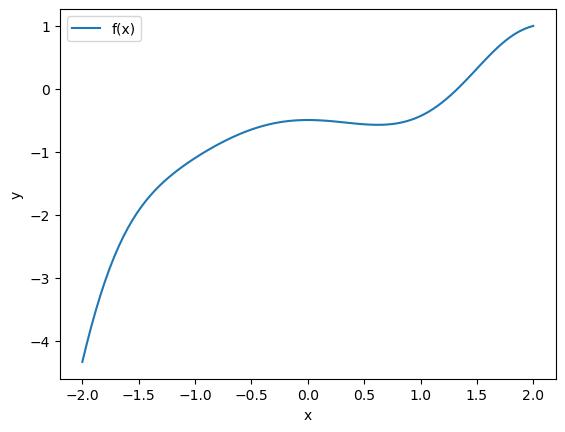

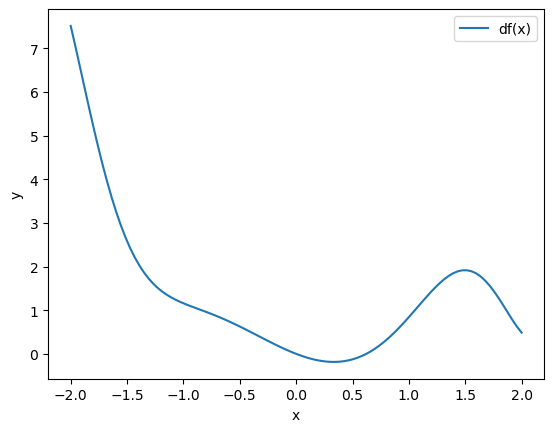

In [2]:
# one dimensional function that we want to approximate as a toy example
def f(x):
    return (x**3)/3 - (x**2)/2 - (1/2)*np.cos(x**2)
def df(x):
    return x**2 - x + np.sin(x**2)*x

N = 100
x = np.linspace(-2, 2, N)
y = f(x)
dx = df(x)

draw_1d(x, y)
draw_1d(x, dx, label='df(x)')

## **Approximation Extreme Learning Machine**

### In the following we always assume that we know the following dataset: $D = \{x_i, dx_i\}_{i = 1}^{K}$ where $dx_i = \frac{df(x)}{dx}(x_i)$ and also the value $f_0 = f(x_0)$ at a single point $x_0 \in \mathbb{R}$,

### and we want to be able to approximate $f(x)$ at any $x\ \in \mathbb{R}$, i.e. learn the mapping $f(x)$.

In [3]:
# Sample training dataset
K = 15
x_train_values = np.linspace(-2, 2, K)
x_train_derivs = df(x_train_values)
x0 = np.array([0])
f0 = f(x0)

# Sample points that we want to predict
N = 13
x_predict = np.linspace(-2, 2, N)
y_true = f(x_predict)

### If we use a single hidden layer with $M$ neurons with a non-linear activation, which takes the input $x$ and should output $f(x)$ for $x \in \mathbb{R}$. With first layer weights $w^{(1)} \in \mathbb{R}^M$ and last layer weights $w^{(2)} \in \mathbb{R}^{1 \times M} \in \mathbb{R}$ we get the following approximation for a data point $x_i \in \mathbb{R}$ (single feature dimension) $\hat{f}(x_i) = \Phi^{(2)}(x_i) \approx f(x_i)$:

### $$ \Phi^{(0)}(x_i) = x_i \in \mathbb{R}$$

### $$ \Phi^{(1)}(x_i) = \phi(w^{(1)} \Phi^{(0)}(x_i)) = \phi(w^{(1)} x_i) \in \mathbb{R}^M $$

### $$ \Phi^{(2)}(x_i) = w^{(2)} \Phi^{(1)}(x_i) = \bigg( \sum^{M}_{j=1} w^{(2)}_{j} \big( \Phi^{(1)}(x_i) \big)_{j} \bigg) = \bigg( \sum^{M}_{j=1} w^{(2)}_{j} \big( \phi(w^{(1)} x_i) \big)_{j} \bigg) = \hat{f}(x_i) \approx f(x_i) $$

### We initialize the weights of the first layer $w^{(1)}$ completely randomly using uniform distribution between $-1$ and $1$, and also using a standard normal distribution ($0$ mean and a small standard deviation). Idea is to break symmetry and ensure that each hidden neuron learns a different feature?? Since we do random initialization we don't need bias for the first layer weights, and for the second layer weights we will compute them directly using least squares, so we don't put bias there neither.


### Since we assume we know the derivatives, we can set up the following system: $\frac{\partial \hat{f}(x)}{\partial x} \approx \frac{\partial fx}{\partial x}$ 

### $$ \frac{\partial}{\partial x} \hat{f}(x) = \frac{\partial}{\partial x} \bigg( \sum^{M}_{j=1} w^{(2)}_{j} \big( \phi(w^{(1)} x_i) \big)_{j} \bigg) = \bigg( \sum^{M}_{j=1} w^{(2)}_{j} \frac{\partial}{\partial x} \big( \phi(w^{(1)} x_i) \big)_{j} \bigg) $$

### For more readability let's use $w = w^{(2)}$ and $c = w^{(1)}$ and let's use $a_i = \frac{\partial}{\partial x} \big( \phi(c x_i) \big) \in \mathbb{R}^{M}$ and $a_{ij} = \frac{\partial}{\partial x} \big( \phi(c x_i) \big)_{j}$ which we can easily compute using automatic differentiation using popular libraries. In the end we get a linear system of $K$ linear equations with $M$ unknowns in total. 

### $$ \frac{\partial}{\partial x} \hat{f}(x_1) = \bigg( \sum^{M}_{j=1} w_j a_{1j} \bigg) \approx \frac{\partial}{\partial x} f(x_1) $$
### $$ \frac{\partial}{\partial x} \hat{f}(x_2) = \bigg( \sum^{M}_{j=1} w_j a_{2j} \bigg) \approx \frac{\partial}{\partial x} f(x_2) $$
### $$ .... $$
### $$ \frac{\partial}{\partial x} \hat{f}(x_K) = \bigg( \sum^{M}_{j=1} w_j a_{Kj} \bigg) \approx \frac{\partial}{\partial x} f(x_K) $$

### which is same as solving the linear system $A \, w = b$ where $A = (a_{ij}) \in \mathbb{R}^{K \times M}$ as defined above. So we have:

### $$ A \, w = \begin{bmatrix} \frac{\partial}{\partial x} \phi(c x_1) \\ \frac{\partial}{\partial x} \phi(c x_2) \\ \vdots \\ \frac{\partial}{\partial x} \phi(c x_K) \end{bmatrix} \, \begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_M \end{bmatrix} \overset{!}{=} \begin{bmatrix} \frac{\partial f(x)}{\partial x}(x_1) \\ \frac{\partial f(x)}{\partial x}(x_2) \\ \vdots \\ \frac{\partial f(x)}{\partial x}(x_K) \end{bmatrix}$$

### We also assume we know an intial value $f_0$ at $x_0$ so we add this linear equation as well. Overall we have the following formulation which we can solve for $w$:

### $$ A \, w = \begin{bmatrix} \frac{\partial}{\partial x} \phi(c x_1) \\ \frac{\partial}{\partial x} \phi(c x_2) \\ \vdots \\ \frac{\partial}{\partial x} \phi(c x_K) \\ \phi(c x_0) \end{bmatrix} \, \begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_M \end{bmatrix} \overset{!}{=} \begin{bmatrix} \frac{\partial f(x)}{\partial x}(x_1) \\ \frac{\partial f(x)}{\partial x}(x_2) \\ \vdots \\ \frac{\partial f(x)}{\partial x}(x_K) \\ f_0 \end{bmatrix}$$

### $$ A \in \mathbb{R}^{(K+1) \times M}, w \in \mathbb{R}^{M}, b \in \mathbb{R}^{K+1} $$

Initial model loss: 1.9887540159760575



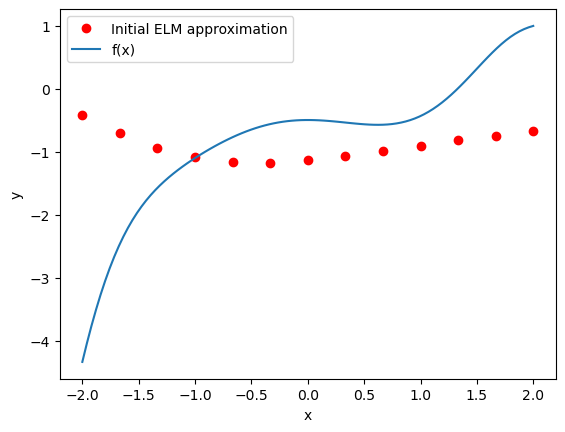

In [4]:
# define the parameters
M = 8
regularization_scale = 1e-8 # for the lstsq, same as bertalan-2019
model = ELM(x_train_values, x_train_derivs, x0, f0, n_hidden=M, activation=np.tanh, rcond=regularization_scale, verbose=False)

# model initial prediction 
phi_2 = model.forward(x_predict)
print('Initial model loss:', model.evaluate(x_predict, y_true))

draw_1d(x, y, xpredict=x_predict, ypredict=phi_2, labelpredict='Initial ELM approximation')

Model loss: 0.00026827976013574706



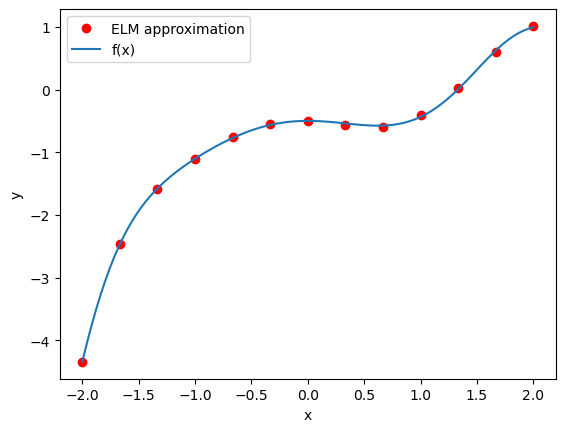

In [5]:
# fit the model using the training values
model.fit()

# model's trained prediction 
phi_2 = model.forward(x_predict)
print('Model loss:', model.evaluate(x_predict, y_true))

draw_1d(x, y, xpredict=x_predict, ypredict=phi_2, labelpredict='ELM approximation', save='./pictures/elm_' + str(M) + '.png')